
# Swiss Post TSP experiment — MTZ vs. DFJ - Part 1 

This notebook compares two **direct MILP** formulations for the Euclidean Traveling Salesman Problem (TSP):

- **MTZ** (Miller–Tucker–Zemlin) which you have to implement.
- **Full DFJ** (Dantzig–Fulkerson–Johnson) with *all* subtour elimination constraints enumerated explicitly (provided here bellow).

We report the runtime for each method:

1. **Solver runtime**: `model.Runtime` reported by Gurobi (time spent in the optimizer).

This code is for question 1 and 2



## Mathematical formulations

We consider a complete directed graph $G=(V,A)$ on $n$ nodes with distances $c_{ij}$ for $i\neq j$.
Decision $x_{ij}\in\{0,1\}$ indicates whether arc $(i,j)$ is in the tour.


### DFJ (Dantzig–Fulkerson–Johnson) with all subtour constraints

\begin{align*}
\min \quad & \sum_{i\in V}\sum_{j\in V\setminus\{i\}} c_{ij} x_{ij} \\[2mm]
\text{s.t.}\quad 
& \sum_{j\in V\setminus\{j\}} x_{ij} = 1 \quad \forall j\in V, \\
& \sum_{j\in V\setminus\{i\}} x_{ji} = 1 \quad \forall i\in V, \\[1mm]
& \sum_{i\in S}\sum_{j\in S,\,j\ne i} x_{ij} \le |S|-1 \quad \forall S\subset V,\ 2\le |S|\le n-1, \\
& x_{ij}\in\{0,1\}.
\end{align*}

For DFJ we enumerate **all** nontrivial subsets $S$, i.e., $2\leq |S|\leq n-1$. The number of such sets is $2^{n}-n-2$, which grows rapidly.


# MTZ (Miller–Tucker–Zemlin) 


# Question 1 (2 points): 

MTZ TSP. Formulate the Traveling Salesman Problem as a mixed integer linear program using the Miller–Tucker–Zemlin (MTZ) formulation. Then, in at most 150 words, explain why solving your MTZ model returns the shortest round trip (i.e., why the constraints eliminate subtours and the objective selects a minimum–cost tour). Write all parts of your answer bellow.

 


### Solution

 

In [1]:

import math
import random
import time
import itertools
from typing import Dict, List, Tuple, Any
import math, random
import matplotlib.pyplot as plt

try:
    import gurobipy as gp
    from gurobipy import GRB
    GUROBI_OK = True
except Exception as e:
    GUROBI_OK = False
    print("WARNING: gurobipy is not available in this environment.\n"
          "Install Gurobi and ensure your license is set up to run the solves.")


In [2]:

def generate_instance(n: int = 17, seed: int = 42):
    """This function generate the TSP instance with n nodes and a given random seed. Please do not change the seed (default 42) 
    so that results are reproducible. V is the list of nodes, C is the cost dictionary and coords is the list of coordinates.
    """
    random.seed(seed)
    coords = [(random.uniform(0, 100), random.uniform(0, 100)) for _ in range(n)]
    V = list(range(n))
    def dist(i, j):
        if i == j: return 0.0
        (xi, yi), (xj, yj) = coords[i], coords[j]
        return float(math.hypot(xi - xj, yi - yj))
    C = {(i, j): dist(i, j) for i in V for j in V if i != j}
    return V, C, coords

def successor_tour_from_vars(x, V, depot: int = 0):
    """This function takes as input the decision variables x of a TSP model and returns the tour as a list of nodes, 
    starting and ending at the depot with the correct ordering to submit your answer.
    """
    n = len(V)
    succ = {i: None for i in V}
    for (i, j), var in x.items():
        try:
            val = var.X
        except Exception:
            val = float(var) if not hasattr(var, "X") else var.X
        if val > 0.5:
            succ[i] = j
    tour = [depot]
    seen = {depot}
    cur = depot
    for _ in range(n - 1):
        nxt = succ[cur]
        if nxt is None:
            break
        tour.append(nxt)
        if nxt in seen:
            break
        seen.add(nxt)
        cur = nxt
    if tour and tour[0] != tour[-1] and succ.get(cur, None) == depot:
        tour.append(depot)
    return tour


In [ ]:
def solve_by_MTZ(Cost: dict, V: list, n:int):
    # n = len(V)
    model = gp.Model("MTZ")
    x = model.addVars(Cost.keys(), vtype=gp.GRB.BINARY, name="x")
    u = model.addVars(list(range(n)), vtype=gp.GRB.INTEGER, name='u')
    model.setObjective(gp.quicksum(Cost[i, j] * x[i, j] for (i, j) in Cost),sense=gp.GRB.MINIMIZE)
    model.addConstr(u[0] == 0, name=f'fix_depot')
    #degree contraint
    for i in V:
        model.addConstr(gp.quicksum(x[i, j] for j in V if j != i) == 1, name=f"out_{i}")
        model.addConstr(gp.quicksum(x[j, i] for j in V if j != i) == 1, name=f"in_{i}")
    #ordering constraint
    for i in range(1,n):
        #add lower bound to only u[1] to u[n-1]
        model.addConstr(u[i] >= 1, name=f'u[{i}]_lower_bound')
        model.addConstr(u[i] <= n-1, name=f'u[{i}]_upper_bound' )
        for j in range(1,n):
            if i == j: # only dissimilar indices
                continue
            else:
                model.addConstr(u[i] + 1 <= (n-1)*(1-x[i,j]) + u[j] , name=f'contraint_ordering_{i}{j}')
    
    model.update()
    try:
        model.computeIIS()
        model.write("./results/iis.ilp")
    except gp._exception.GurobiError as e:
        print(e)
    model.update()
    model.optimize()
    model.write("./results/model.lp")
    status = model.Status
    obj = model.ObjVal if model.SolCount > 0 else float("nan")
    gap = model.MIPGap if hasattr(model, "MIPGap") else float("nan")
    tour = []
    if model.Solcount > 1:
        tour = successor_tour_from_vars(x,V,depot=0)
    else:
        tour = []
    result = {
        "name": "SmallMTZ",
        "status": status,
        "obj": obj,
        "gap": gap,
        "tour": tour,
        "solver_runtime_sec": model.Runtime,  
        "n": len(V),
        "num_arcs": len(Cost),
    }
    return result, x, tour, u
print("hi gavin")

# Question 2 (8 points).

Implement and solve two TSP models in Python with Gurobi on the starter instance provided above:

MTZ formulation: implement it yourself using your model from Question 1.

DFJ formulation: use the implementation provided bellow.

Write all answers bellow.



In [1]:
 ### Type your code for the MTZ model here ###
 # You may want to leverage the code for the function: solve_dfj_full(...) provided bellow.

In [2]:

def all_nontrivial_subsets(V):
    n = len(V)
    for k in range(2, n):
        for S in itertools.combinations(V, k):
            yield S

def solve_dfj_full(V, C, time_limit: int = 99999, log_to_console: int = 1):
    if not GUROBI_OK:
        raise RuntimeError("gurobipy not available.")
    n = len(V)
    model = gp.Model("TSP_DFJ_FULL")
    model.Params.OutputFlag = log_to_console
    model.Params.TimeLimit = time_limit

    # decision vars
    x = model.addVars(C.keys(), vtype=GRB.BINARY, name="x")

    # objective
    model.setObjective(gp.quicksum(C[i, j] * x[i, j] for (i, j) in C), GRB.MINIMIZE)

    # degree constraints
    for i in V:
        model.addConstr(gp.quicksum(x[i, j] for j in V if j != i) == 1, name=f"out_{i}")
        model.addConstr(gp.quicksum(x[j, i] for j in V if j != i) == 1, name=f"in_{i}")

    # DFJ constraints: for all nontrivial S
    
    num_subsets = 0
    for S in all_nontrivial_subsets(V):
        Sset = set(S)
        lhs = gp.quicksum(x[i, j] for i in Sset for j in Sset if i != j)
        model.addConstr(lhs <= len(Sset) - 1, name=f"dfj_S_{'_'.join(map(str, S))}")
        num_subsets += 1 
        
    model.update()
    
    model.optimize()

    status = model.Status
    obj = model.ObjVal if model.SolCount > 0 else float("nan")
    gap = model.MIPGap if hasattr(model, "MIPGap") else float("nan")
    tour = successor_tour_from_vars(x, V, depot=0) if model.SolCount > 0 else []

    result = {
        "name": "DFJ (all subsets)",
        "status": status,
        "obj": obj,
        "gap": gap,
        "tour": tour,
        "solver_runtime_sec": model.Runtime,  
        "n": len(V),
        "num_arcs": len(C),
        "num_dfj_subsets": num_subsets
    }
    return model, x, result


# Question 2 

For  each model, report:


 the optimal tour (list the nodes in visiting order, starting and ending at the depot),

 the optimal total travel time,

 the solver runtime (wall‐clock seconds).


Compare the results: Are the optimal tours identical? If not, justify. If the runtimes differ, explain why. Write all answers bellow.

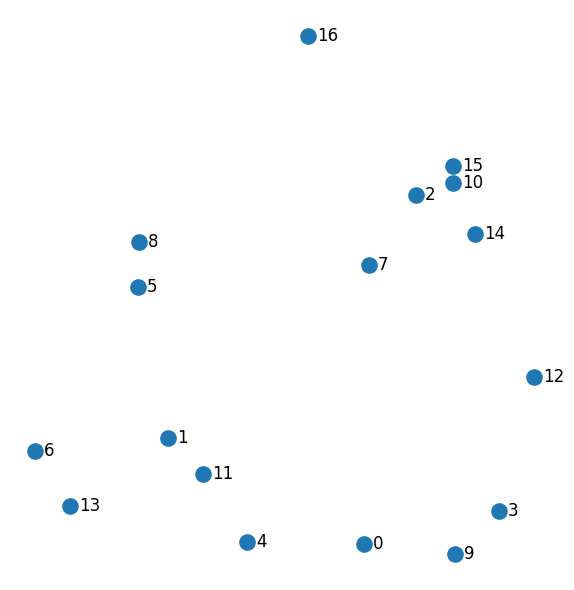

Instance: n=17, |A|=272 (directed arcs)

Solving DFJ with ALL subsets
Set parameter Username
Set parameter LicenseID to value 2712266
Academic license - for non-commercial use only - expires 2026-09-23
Set parameter OutputFlag to value 1
Set parameter TimeLimit to value 9999
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (linux64 - "Linux Mint 22.2")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  9999

Optimize a model with 131087 rows, 272 columns and 8913168 nonzeros
Model fingerprint: 0xb99e974f
Variable types: 0 continuous, 272 integer (272 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 913.0878119
Presolve removed 0 rows and 0 columns (presolve time = 6s)...
Preso

,name,obj,gap,solver_runtime_sec
0,DFJ (all subsets),340.479524,0.0,46.909466
1,DFJ (all subsets),340.479524,0.0,46.909466


In [5]:

# Set instance size and random seed
n = 17
seed = 42



V, C, coords = generate_instance(n=n, seed=seed)

xs, ys = zip(*coords)
fig, ax = plt.subplots(figsize=(6, 6))

# Bigger nodes
ax.scatter(xs, ys, s=120, zorder=3)

# Label each node larger and slightly to the right
dx = 0.018 * (max(xs) - min(xs))  # horizontal offset
for idx, (x, y) in enumerate(coords):
    ax.text(x + dx, y, f"{idx}", fontsize=12, va="center", ha="left")

ax.set_aspect("equal", adjustable="box")
ax.axis("off")
fig.tight_layout()
plt.show()

print(f"Instance: n={len(V)}, |A|={len(C)} (directed arcs)")








if GUROBI_OK:
     
    print("\nSolving DFJ with ALL subsets")
    dfj_model, dfj_x, dfj_res = solve_dfj_full(V, C, time_limit=9999, log_to_console=1)
    print(f"DFJ objective (distance): {dfj_res['obj']:.6f}")
    print(f"DFJ MIP gap: {dfj_res['gap']:.6g}")
    print(f"DFJ subsets added: {dfj_res['num_dfj_subsets']}")
    print(f"DFJ solver runtime (s):   {dfj_res['solver_runtime_sec']:.3f}") 
    print(f"DFJ tour: {dfj_res['tour']}")

    # Optional: tabular summary if pandas is available
    try:
        import pandas as pd
        import numpy as np
        TO_COMPLETE = dfj_res # Replace with MTZ results that you obtain if possible, otherwise please write your result in a Markdown cell below.
        summ = pd.DataFrame([TO_COMPLETE, dfj_res])[
            ["name","obj","gap","solver_runtime_sec"]
        ]
        display(summ)
    except Exception:
        pass
else:
    print("Gurobi not available. Please run this notebook on a machine with gurobipy installed.")


# Solution
### Type your answers for the second part of Question 2 here bellow.